In [ ]:
#########################################################################################################################################
#########################################################################################################################################
#########################################################################################################################################

In [113]:
#########################################################################################################################################
#########################################################################################################################################
#########################################################################################################################################

In [96]:
# PACKAGE LIST: pip list

import scanpy as sc
import scirpy as ir
import pandas as pd
import muon as mu
import csv
import anndata
import matplotlib.pyplot as plt
import celltypist as celltypist
from celltypist import models

import numpy as np
import seaborn as sns 
from scipy.stats import median_abs_deviation
from cycler import cycler

from matplotlib import cm as mpl_cm

In [114]:
#########################################################################################################################################
#########################################################################################################################################
#########################################################################################################################################

In [3]:
# Sample List 
samples = {
    "9680-L": {"group": "F1", 'batch':'Liver'},
    "9932-L": {"group": "F2", 'batch':'Liver'},
    "9961-L": {"group": "F0", 'batch':'Liver'},
    "9991-L": {"group": "F2", 'batch':'Liver'},
    "9999-L": {"group": "F0", 'batch':'Liver'},
    "10113-1-L": {"group": "F1", 'batch':'Liver'},
    "10113-2-L": {"group": "F0", 'batch':'Liver'},
    "10202-L": {"group": "F1", 'batch':'Liver'},
    "10203-L": {"group": "F1", 'batch':'Liver'},
    "10205-L": {"group": "F2", 'batch':'Liver'},
    "10291-2-L": {"group": "F1", 'batch':'Liver'},
    "10380-L": {"group": "F1", 'batch':'Liver'},
}

In [4]:
# Create a list of AnnData objects (one for each sample)
adatas_tcr = {}
adatas_gex = {}
for sample in samples.keys():
    adata_gex=sc.read_10x_h5('GC-WL-'+sample+'_filtered_feature_bc_matrix.h5')
    adata_tcr = ir.io.read_10x_vdj('GC-WL-'+sample+'-TCR_filtered_contig_annotations.csv')
    # concatenation only works with unique gene names
    adata_gex.var_names_make_unique()
    adatas_tcr[sample] = adata_tcr
    adatas_gex[sample] = adata_gex

C:\Users\gaura\miniconda3\Lib\site-packages\anndata\utils.py:334: ExperimentalFeatureWarning: Support for Awkward Arrays is currently experimental. Behavior may change in the future. Please report any issues you may encounter!
  warnings.warn(msg, category, stacklevel=stacklevel)


In [5]:
# Merge anndata objects into one mdata object
adataM_gex = anndata.concat(adatas_gex, index_unique="_")
adataM_tcr = anndata.concat(adatas_tcr, index_unique="_")
mdata = mu.MuData({"gex": adataM_gex, "airr": adataM_tcr})

In [6]:
# Set global metadata on `mdata.obs['x']`
mdata.obs["sample"] = mdata.obs_names.to_series().str.split("_", expand=True)[1]
mdata.obs["group"] = mdata.obs["sample"].map(lambda x: samples[x]["group"])
mdata.obs["batch"] = mdata.obs["sample"].map(lambda x: samples[x]["batch"])

In [115]:
#########################################################################################################################################
#########################################################################################################################################
#########################################################################################################################################

In [116]:
#########################################################################################################################################
#########################################################################################################################################
#########################################################################################################################################

In [ ]:
# 1.1 Calculating quality control metrics

In [119]:
#########################################################################################################################################
#########################################################################################################################################
#########################################################################################################################################

In [14]:
# Defining genes:

# mitochondrial genes
mdata['gex'].var["mt"] = mdata['gex'].var_names.str.startswith("MT-")
# ribosomal genes
mdata['gex'].var["ribo"] = mdata['gex'].var_names.str.startswith(("RPS", "RPL"))
# hemoglobin genes.
mdata['gex'].var["hb"] = mdata['gex'].var_names.str.contains(("^HB[^(P)]"))

In [15]:
# Quality control metrics
sc.pp.calculate_qc_metrics(
    mdata['gex'], qc_vars=["mt", "ribo", "hb"], inplace=True, percent_top=[20], log1p=True
)

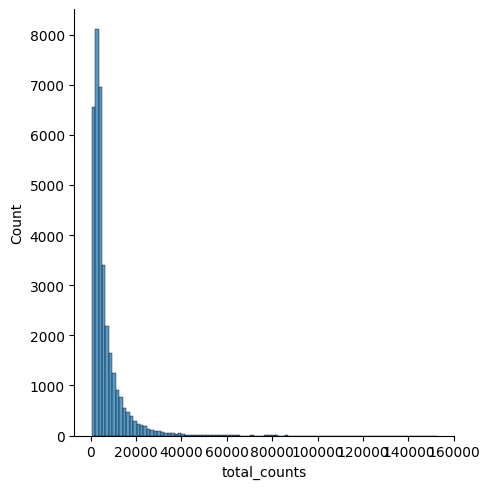

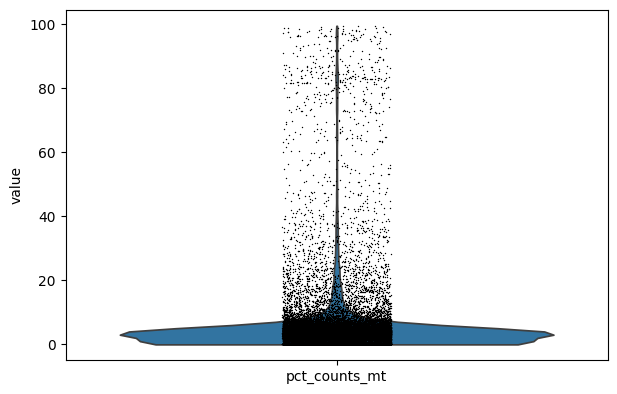

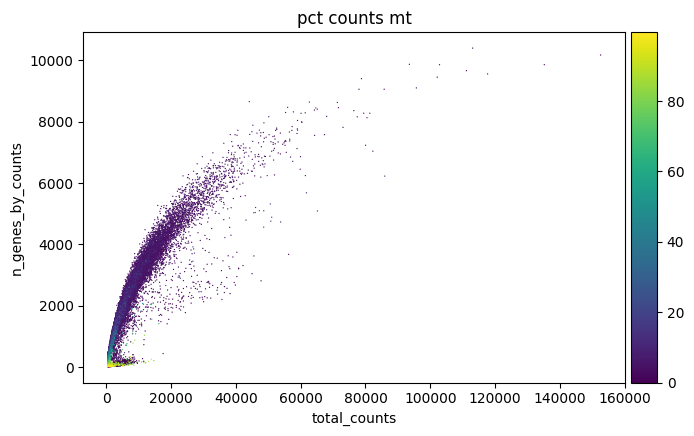

In [21]:
# QC metric plots
p1 = sns.displot(mdata['gex'].obs["total_counts"], bins=100, kde=False)
p2 = sc.pl.violin(mdata['gex'], "pct_counts_mt")
p3 = sc.pl.scatter(mdata['gex'], "total_counts", "n_genes_by_counts", color="pct_counts_mt")

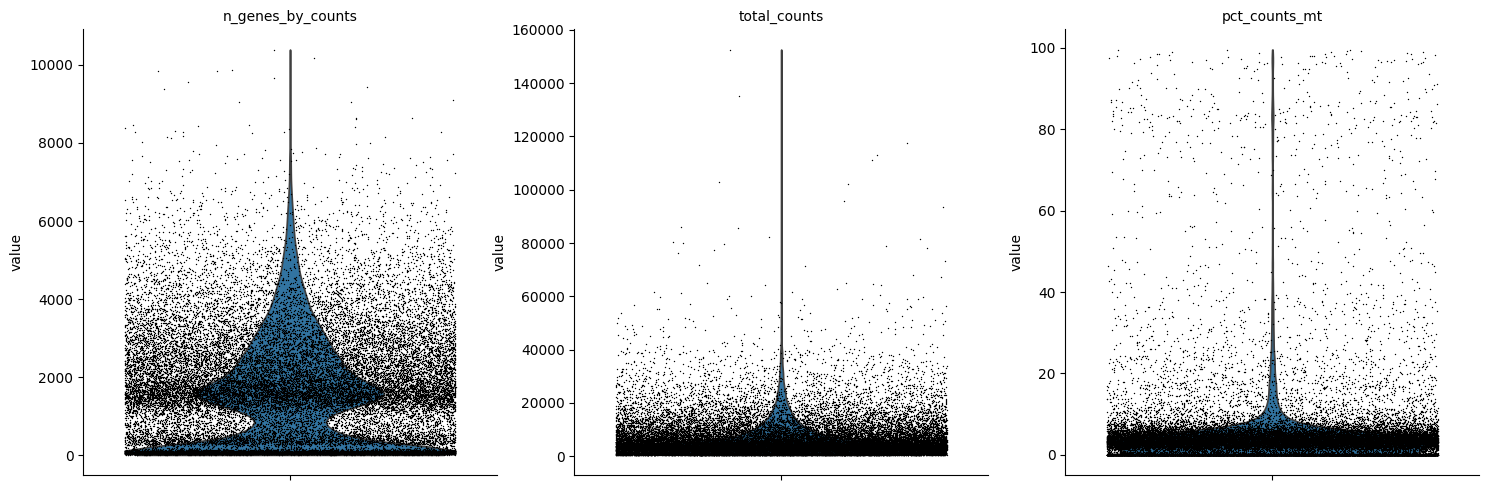

In [23]:
sc.pl.violin(mdata['gex'], ["n_genes_by_counts", "total_counts", "pct_counts_mt"], jitter=0.4, multi_panel=True)

In [117]:
#########################################################################################################################################
#########################################################################################################################################
#########################################################################################################################################

In [24]:
# 1.2 Filtering low quality cells

In [118]:
#########################################################################################################################################
#########################################################################################################################################
#########################################################################################################################################

In [26]:
# Creating threshold function of MAD (median absolute deviaitons) for filtering
def is_outlier(adata, metric: str, nmads: int):
    M = adata.obs[metric]
    outlier = (M < np.median(M) - nmads * median_abs_deviation(M)) | (
        np.median(M) + nmads * median_abs_deviation(M) < M
    )
    return outlier

In [27]:
# Filtering based on threshold of 5 MAD
mdata['gex'].obs["outlier"] = (
    is_outlier(mdata['gex'], "log1p_total_counts", 5)
    | is_outlier(mdata['gex'], "log1p_n_genes_by_counts", 5)
    | is_outlier(mdata['gex'], "pct_counts_in_top_20_genes", 5)
)
mdata['gex'].obs.outlier.value_counts()

outlier
False    24965
True     10092
Name: count, dtype: int64

In [46]:
# Additional filtering of cells with high mitochdonrial counts
mdata['gex'].obs["mt_outlier"] = is_outlier(mdata['gex'], "pct_counts_mt", 3) | (
    mdata['gex'].obs["pct_counts_mt"] > 8
)
mdata['gex'].obs.mt_outlier.value_counts()

mt_outlier
False    31808
True      3249
Name: count, dtype: int64

In [47]:
adata=mdata['gex']
adata.obs['sample']=mdata.obs['sample']
adata.obs['group']=mdata.obs['group']
adata.obs['batch']=mdata.obs['batch']

In [48]:
test=mdata.copy()

#filtering them out to make liver samples for each patient
mu.pp.filter_obs(test, "gex:sample", lambda x: ~np.isin(x, ["9680-S", "9932-S",'9961-S','9991-S','9999-S','10113-1-S','10113-2-S','10202-S','10203-S','10205-S','10291-2-S','10380-S']))
mdata['gex'].obs['liver']=test['gex'].obs['sample']

del test


In [49]:
print(f"Total number of cells: {adata.n_obs}")
adata = adata[(~adata.obs.outlier) & (~adata.obs.mt_outlier)].copy()

print(f"Number of cells after filtering of low quality cells: {adata.n_obs}")

Total number of cells: 35057
Number of cells after filtering of low quality cells: 22616


In [54]:
# Saving new filtered mdata
mdata = mu.MuData({"gex": adata, "airr": adataM_tcr})
# Set global metadata on `mdata.obs`
mdata.obs["sample"] = mdata.obs_names.to_series().str.split("_", expand=True)[1]
mdata.obs["group"] = mdata.obs["sample"].map(lambda x: samples[x]["group"])
mdata.obs["batch"] = mdata.obs["sample"].map(lambda x: samples[x]["batch"])

In [56]:
# QC Metric plots post filtration

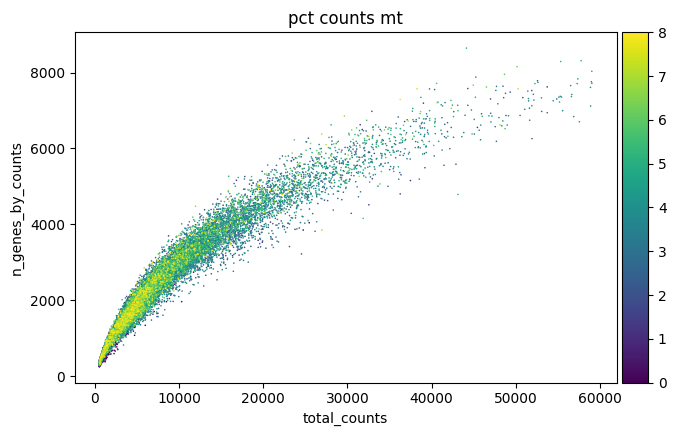

In [53]:
sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt")

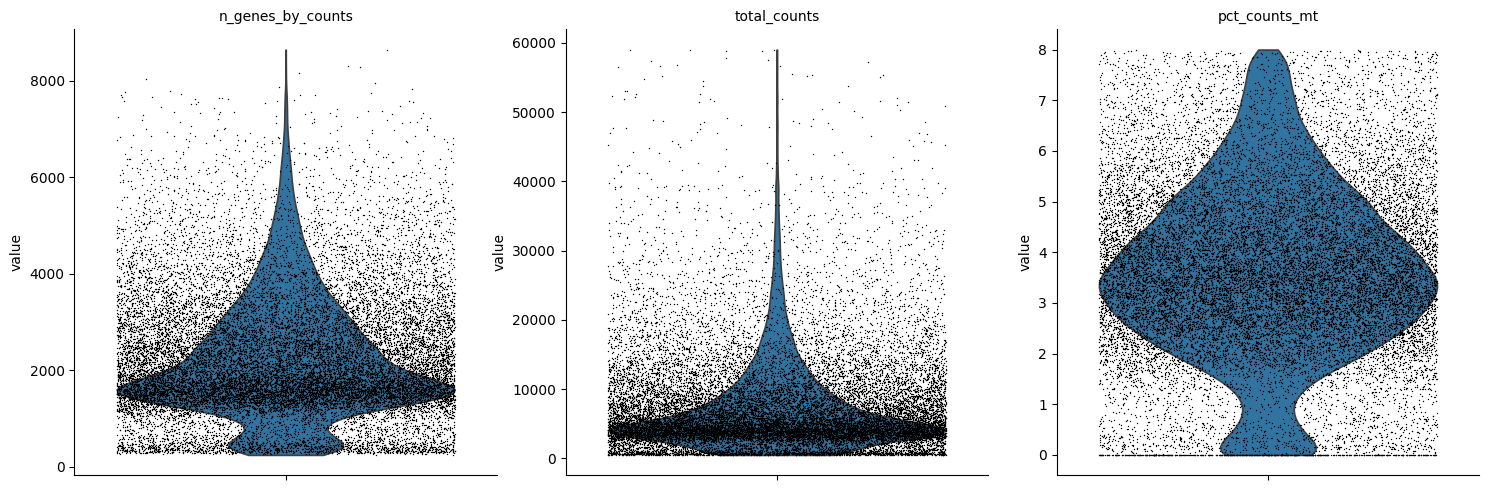

In [55]:
sc.pl.violin(adata, ["n_genes_by_counts", "total_counts", "pct_counts_mt"], jitter=0.4, multi_panel=True)

In [57]:
#########################################################################################################################################
#########################################################################################################################################
#########################################################################################################################################

In [ ]:
# 1.3 Doublet detection

In [ ]:
#########################################################################################################################################
#########################################################################################################################################
#########################################################################################################################################

In [58]:
sc.external.pp.scrublet(adata, batch_key='sample')

In [ ]:
#########################################################################################################################################
#########################################################################################################################################
#########################################################################################################################################

In [59]:
# 1.4 Normalization

In [ ]:
#########################################################################################################################################
#########################################################################################################################################
#########################################################################################################################################

In [60]:
# Saving count data
adata.layers["counts"] = adata.X.copy()

In [61]:
# Normalizing to median total counts
sc.pp.normalize_total(adata)
# Logarithmize the data:
sc.pp.log1p(adata)

In [ ]:
# 1.5 Feature Selection

In [62]:
sc.pp.highly_variable_genes(adata, n_top_genes=2000)

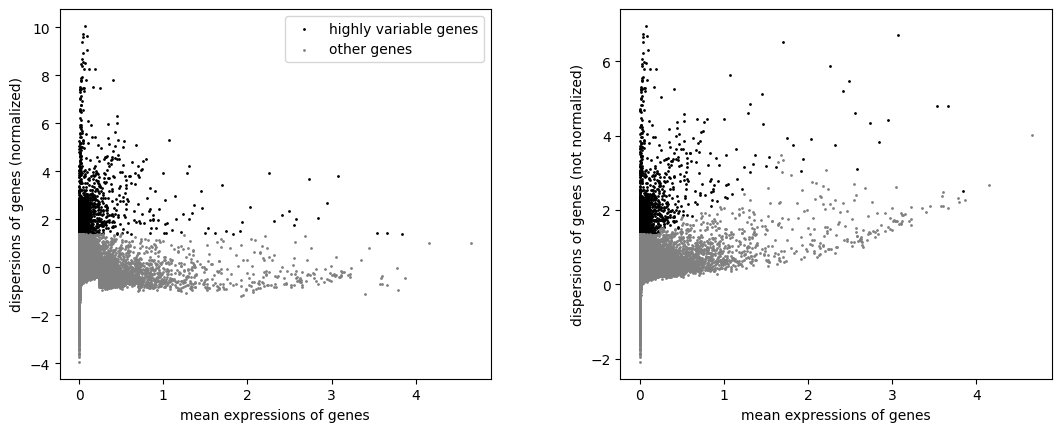

In [63]:
sc.pl.highly_variable_genes(adata)

highly_variable
False    23691
True      2000
Name: count, dtype: int64

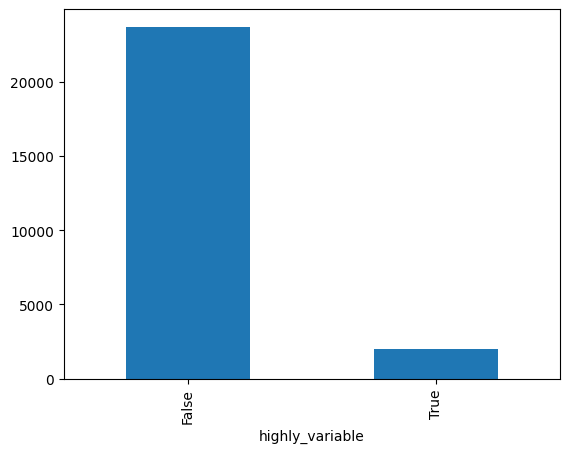

In [64]:
n_batches = adata.var["highly_variable"].value_counts()
ax = n_batches.plot(kind="bar")
n_batches

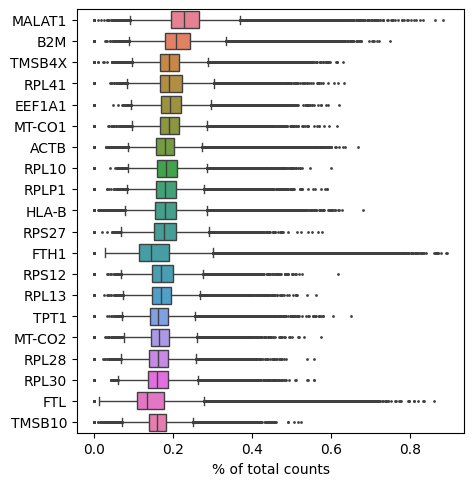

In [65]:
sc.pl.highest_expr_genes(adata, n_top=20)

In [ ]:
#########################################################################################################################################
#########################################################################################################################################
#########################################################################################################################################

In [72]:
# 1.6 Dimensionality Reduction

In [ ]:
#########################################################################################################################################
#########################################################################################################################################
#########################################################################################################################################

In [71]:
#PCA

... storing 'sample' as categorical
... storing 'group' as categorical
... storing 'liver' as categorical


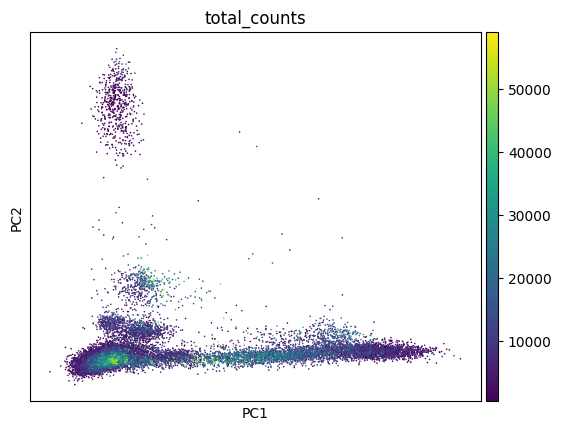

In [67]:
sc.pp.pca(adata, svd_solver="arpack", use_highly_variable=True)
sc.pl.pca_scatter(adata, color="total_counts")

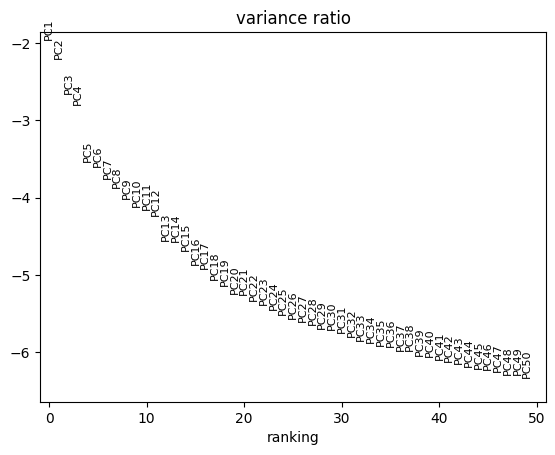

In [68]:
sc.pl.pca_variance_ratio(adata, n_pcs=50, log=True)

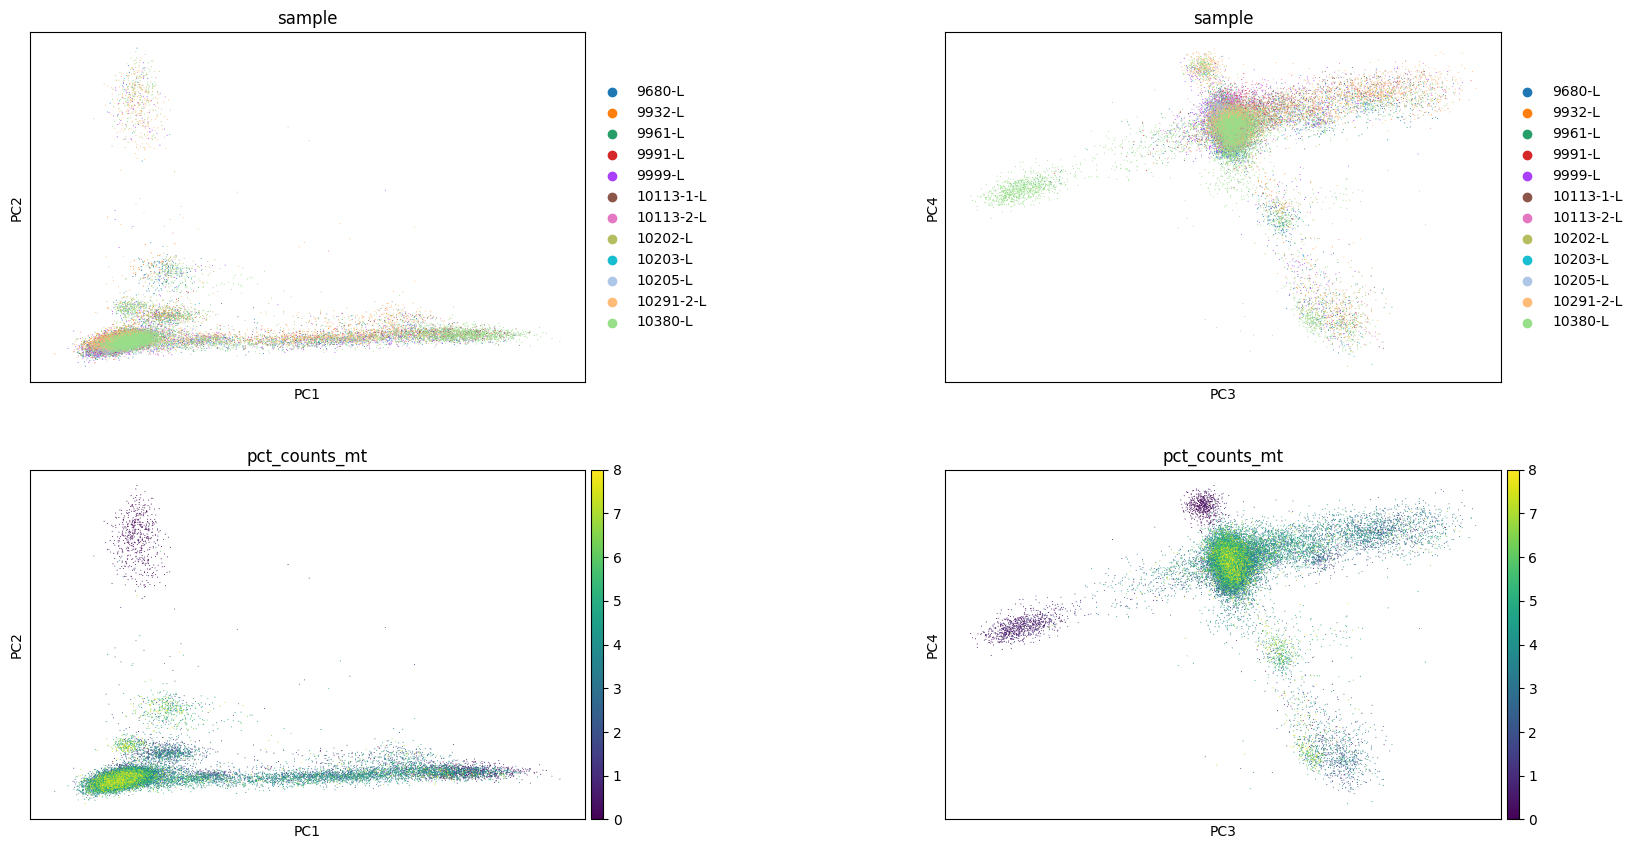

In [89]:
sc.pl.pca(
    adata,
    color=["sample", "sample", "pct_counts_mt", "pct_counts_mt"],
    dimensions=[(0, 1), (2, 3), (0, 1), (2, 3)],
    ncols=2,
    size=2,
    wspace=0.5,
)

In [73]:
#UMAP

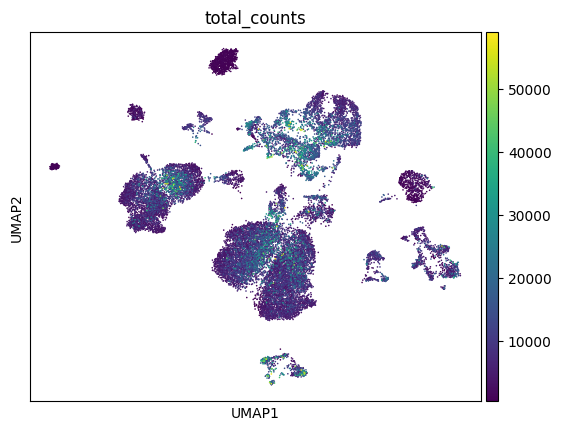

In [74]:
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.pl.umap(adata, color="total_counts")

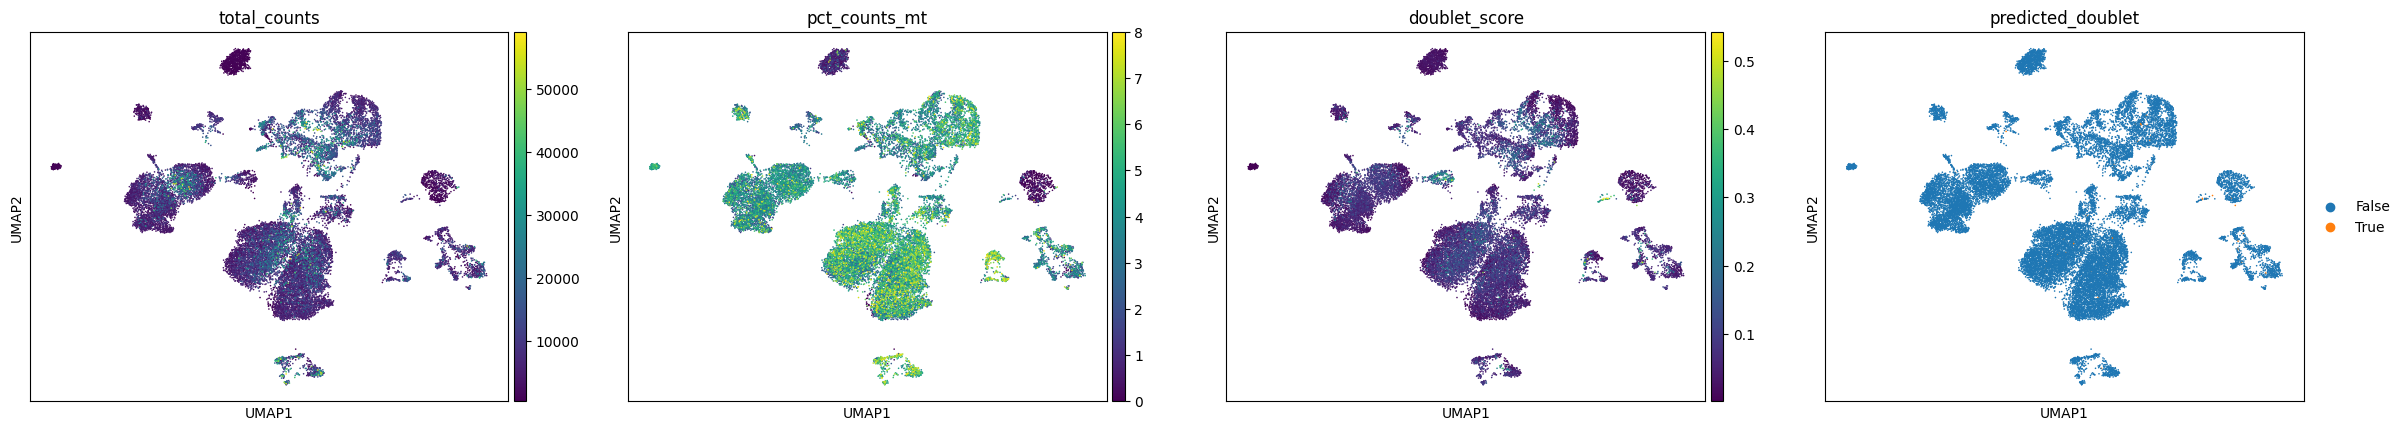

In [75]:
# Inspecting quality control metrics
sc.pl.umap(
    adata,
    color=["total_counts", "pct_counts_mt", "doublet_score", "predicted_doublet"],
)

In [ ]:
#########################################################################################################################################
#########################################################################################################################################
#########################################################################################################################################

In [76]:
# 1.7 Clustering

In [ ]:
#########################################################################################################################################
#########################################################################################################################################
#########################################################################################################################################

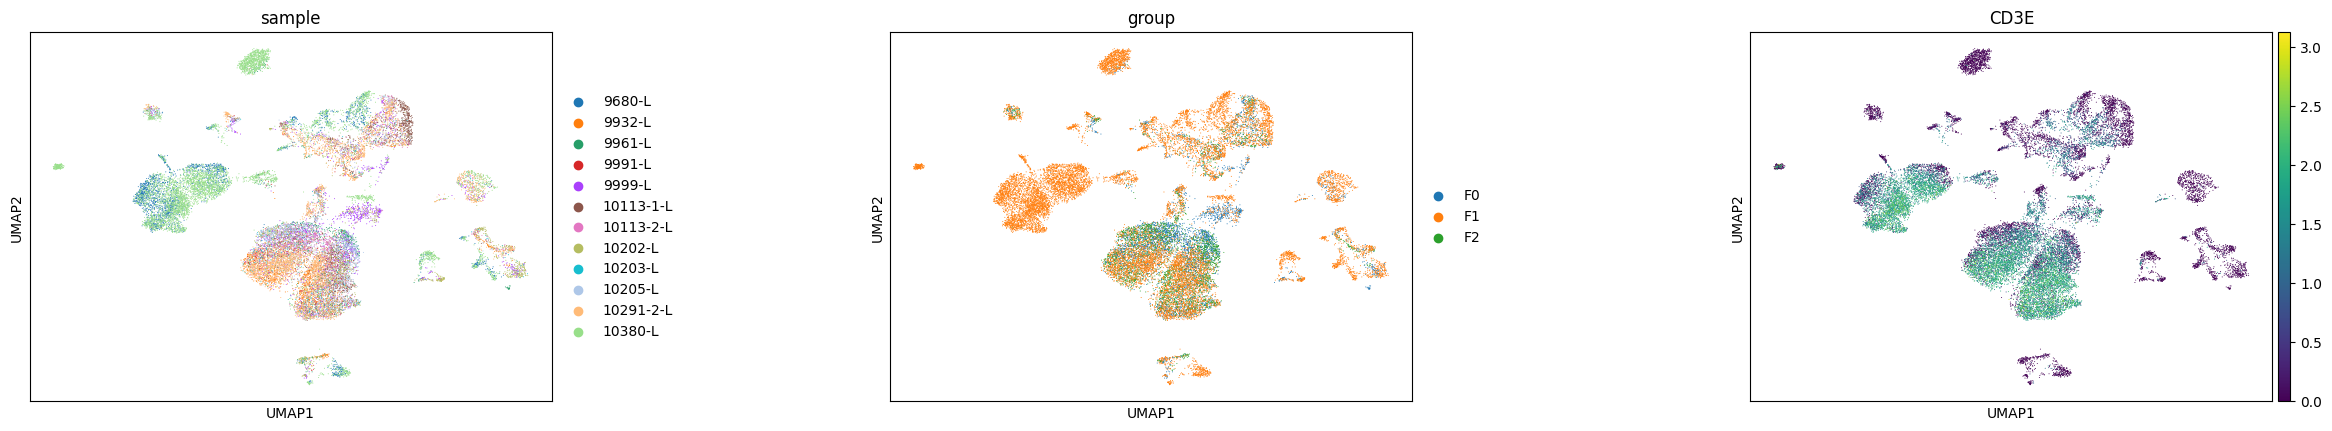

In [90]:
sc.pl.umap(
    adata,
    color=['sample','group','CD3E'], #can add batch to get liver or svp, or group to get f0/1/2
    # Setting a smaller point size to get prevent overlap
    size=2,
    wspace=0.5,
)

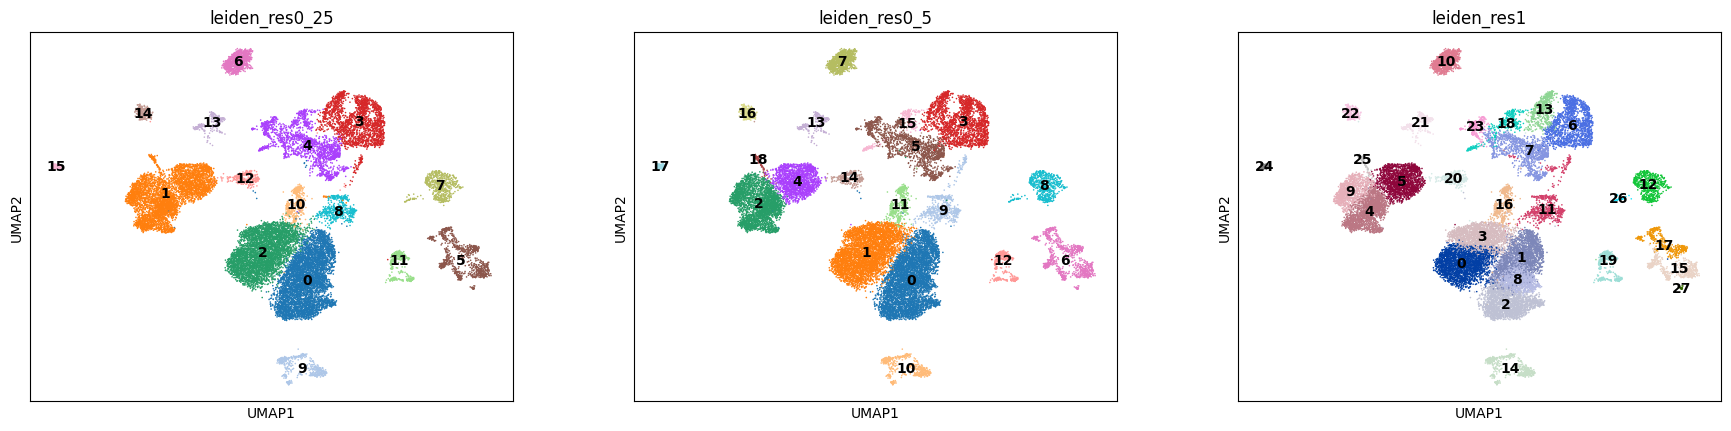

In [87]:
sc.tl.leiden(adata)
sc.tl.leiden(adata, key_added="leiden_res0_25", resolution=0.25)
sc.tl.leiden(adata, key_added="leiden_res0_5", resolution=0.5)
sc.tl.leiden(adata, key_added="leiden_res1", resolution=1.0)
sc.pl.umap(
    adata,
    color=["leiden_res0_25", "leiden_res0_5", "leiden_res1"],
    legend_loc="on data",
)

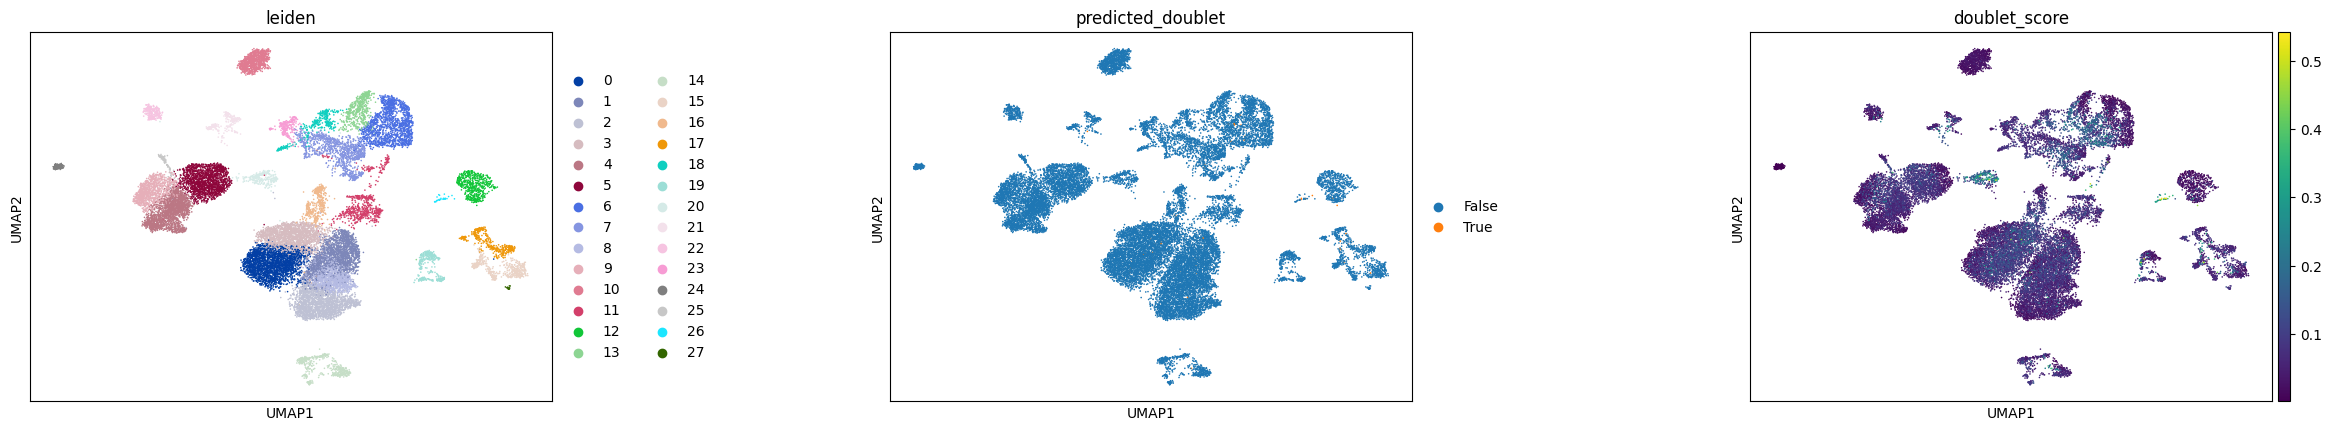

In [88]:
#Reassessing 
adata.obs["predicted_doublet"] = adata.obs["predicted_doublet"].astype("category")
sc.pl.umap(
    adata,
    color=["leiden", "predicted_doublet", "doublet_score"],
    # increase horizontal space between panels
    wspace=0.5,
)

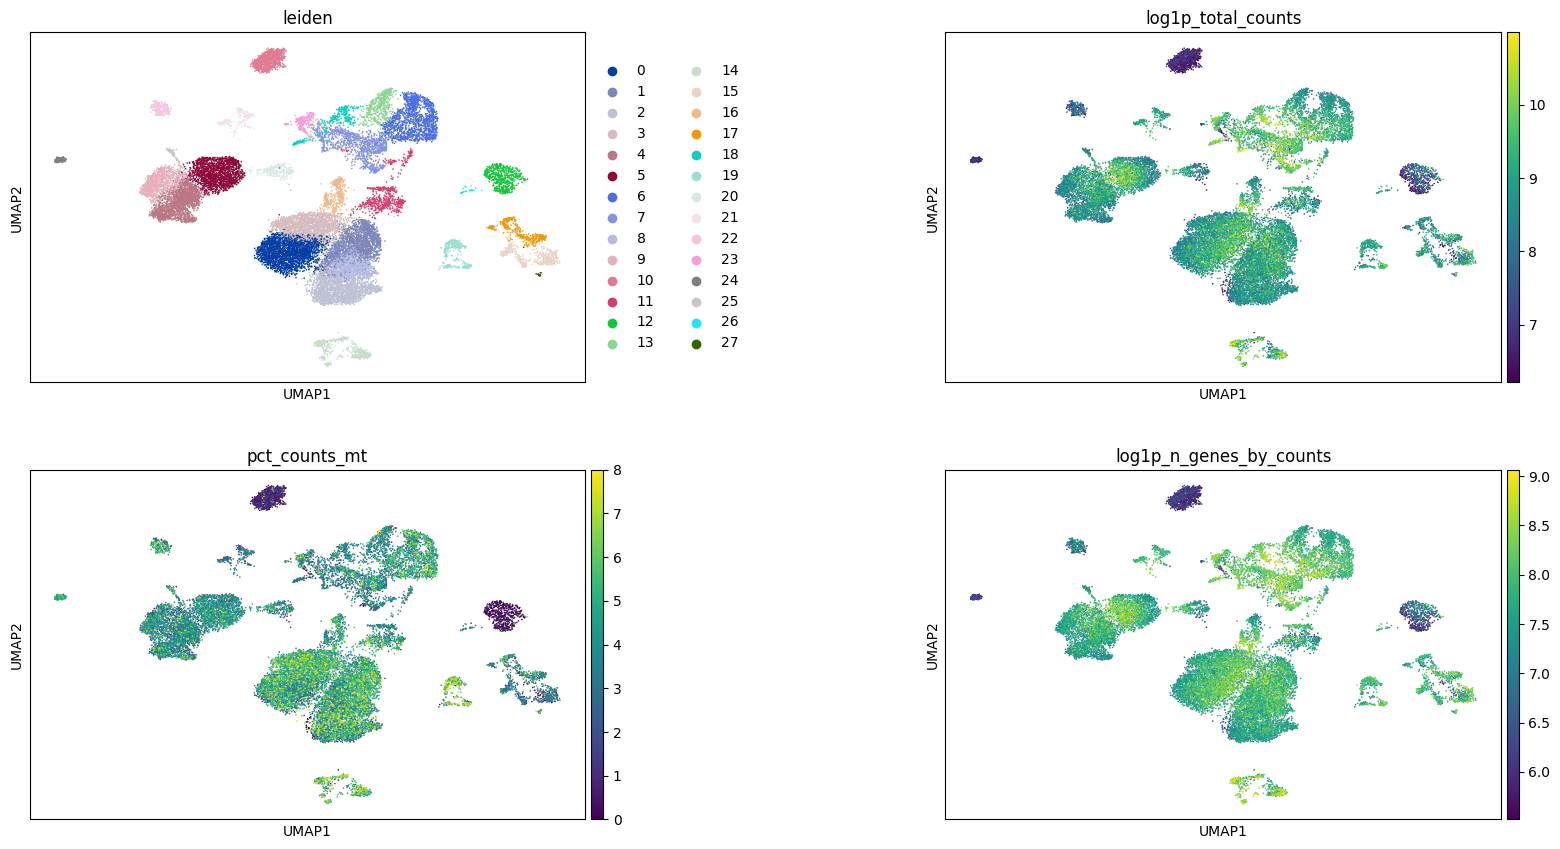

In [92]:
#removing predicted doublets
adata = adata[~adata.obs["predicted_doublet"].to_numpy()].copy()
sc.pl.umap(
    adata, color=["leiden", "log1p_total_counts", "pct_counts_mt", "log1p_n_genes_by_counts"], wspace=0.5, ncols=2
)

In [ ]:
#########################################################################################################################################
#########################################################################################################################################
#########################################################################################################################################

In [93]:
# 1.8 Automatic Cell Type Annotation

In [ ]:
#########################################################################################################################################
#########################################################################################################################################
#########################################################################################################################################

In [94]:
#preparing data for use for celltypist
adata_celltypist = adata.copy()  
# set adata.X to raw counts
adata_celltypist.X = adata.layers["counts"]  
# normalize to 10,000 counts per cell
sc.pp.normalize_per_cell(
    adata_celltypist, counts_per_cell_after=10**4
)  
# log-transform
sc.pp.log1p(adata_celltypist)
# make .X dense instead of sparse, for compatibility with celltypist:
adata_celltypist.X = adata_celltypist.X.toarray()

In [99]:
#Downloading celltypist model to use for cell type annotation
models.download_models(
    force_update=True, model=["Immune_All_Low.pkl"]
)
model_low = models.Model.load(model="Immune_All_Low.pkl")
#Annotation prediction
predictions_low = celltypist.annotate(
    adata_celltypist, model=model_low, majority_voting=True
)

📜 Retrieving model list from server https://celltypist.cog.sanger.ac.uk/models/models.json
📚 Total models in list: 52
📂 Storing models in C:\Users\gaura\.celltypist\data\models
💾 Total models to download: 1
💾 Downloading model [1/1]: Immune_All_Low.pkl
🔬 Input data has 22552 cells and 25691 genes
🔗 Matching reference genes in the model
🧬 6066 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Detected a neighborhood graph in the input object, will run over-clustering on the basis of it
⛓️ Over-clustering input data with resolution set to 15
🗳️ Majority voting the predictions
✅ Majority voting done!


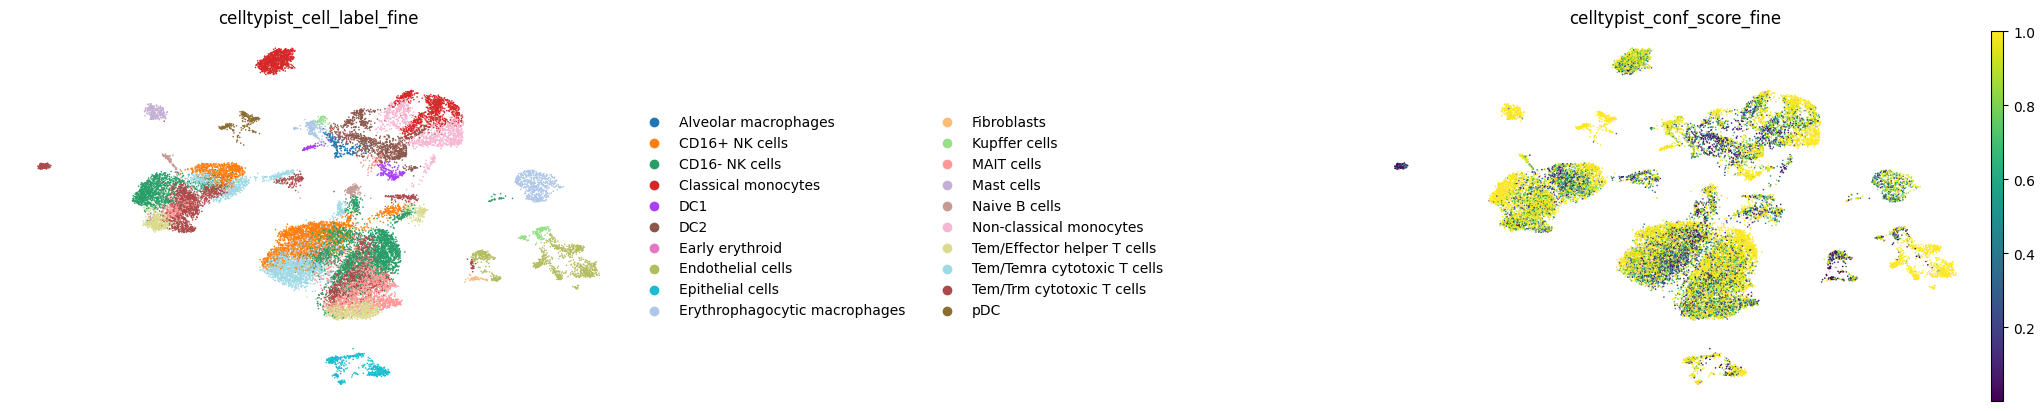

In [102]:
predictions_low_adata = predictions_low.to_adata()
adata.obs["celltypist_cell_label_fine"] = predictions_low_adata.obs.loc[
    adata.obs.index, "majority_voting"
]
adata.obs["celltypist_conf_score_fine"] = predictions_low_adata.obs.loc[
    adata.obs.index, "conf_score"
]
#Plotting celltypist annotations
sc.pl.umap(
    adata,
    color=["celltypist_cell_label_fine", "celltypist_conf_score_fine"], #'CD3E',
    frameon=False,
    sort_order=False,
    wspace=1,
)

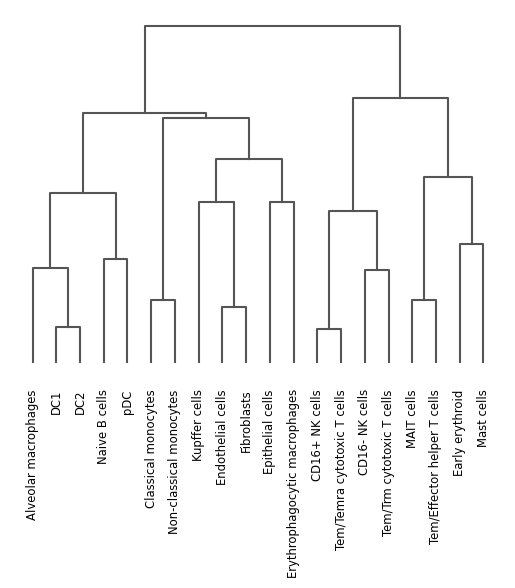

In [104]:
sc.pl.dendrogram(adata, groupby="celltypist_cell_label_fine")
del adata_celltypist

In [ ]:
#########################################################################################################################################
#########################################################################################################################################
#########################################################################################################################################

In [106]:
# 1.9 Celltypist analysis of its annotations

In [ ]:
#########################################################################################################################################
#########################################################################################################################################
#########################################################################################################################################

<Axes: title={'center': 'Liver samples'}, ylabel='celltypist_cell_label_fine'>

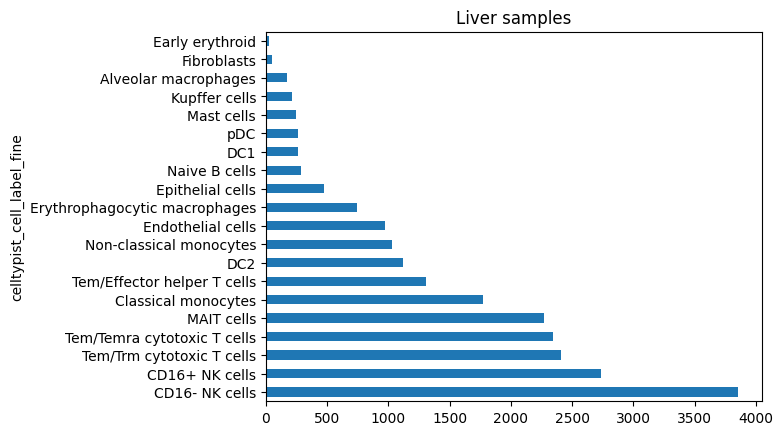

In [107]:
test=adata.obs['celltypist_cell_label_fine'].value_counts()
test.plot.barh(title='Liver samples')

In [108]:
counter=0
indexlist=[]
conflist=[]
celltypelist=[]
for x in adata.obs['celltypist_conf_score_fine']:
    if x<=0.2:
        indexlist.append(counter)
        conflist.append(x)
        celltypelist.append(adata.obs['celltypist_cell_label_fine'][counter])
        counter+=1
df = pd.DataFrame(conflist, columns=['Confidence Score'])
df['Cell Type']=celltypelist
df

Confidence Score                    Cell Type
0             0.146093               CD16+ NK cells
1             0.043519    Tem/Trm cytotoxic T cells
2             0.131140               CD16- NK cells
3             0.148955               CD16+ NK cells
4             0.002020               CD16- NK cells
...                ...                          ...
2601          0.036739                   MAIT cells
2602          0.034469                          DC2
2603          0.173790  Tem/Temra cytotoxic T cells
2604          0.090531                   MAIT cells
2605          0.019671               CD16+ NK cells

[2606 rows x 2 columns]

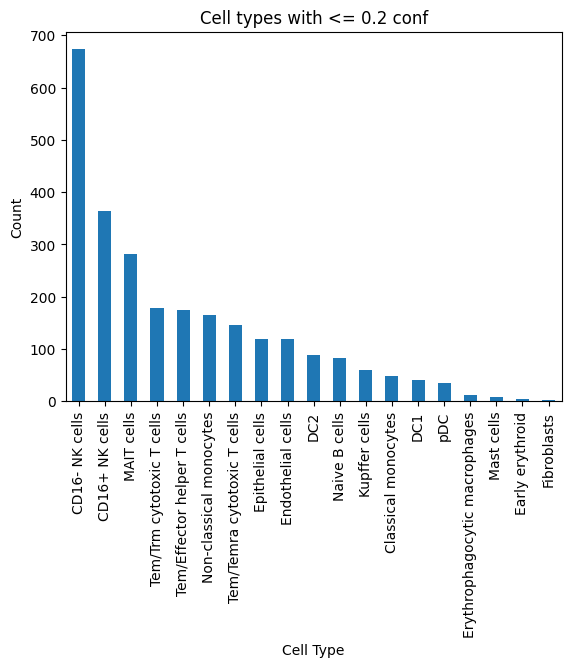

In [109]:
lowconf=df['Cell Type'].value_counts()
# Create a bar plot
lowconf.plot(kind='bar')

# Add labels and title
plt.xlabel('Cell Type')
plt.ylabel('Count')
plt.title('Cell types with <= 0.2 conf')

# Show the plot
plt.show()

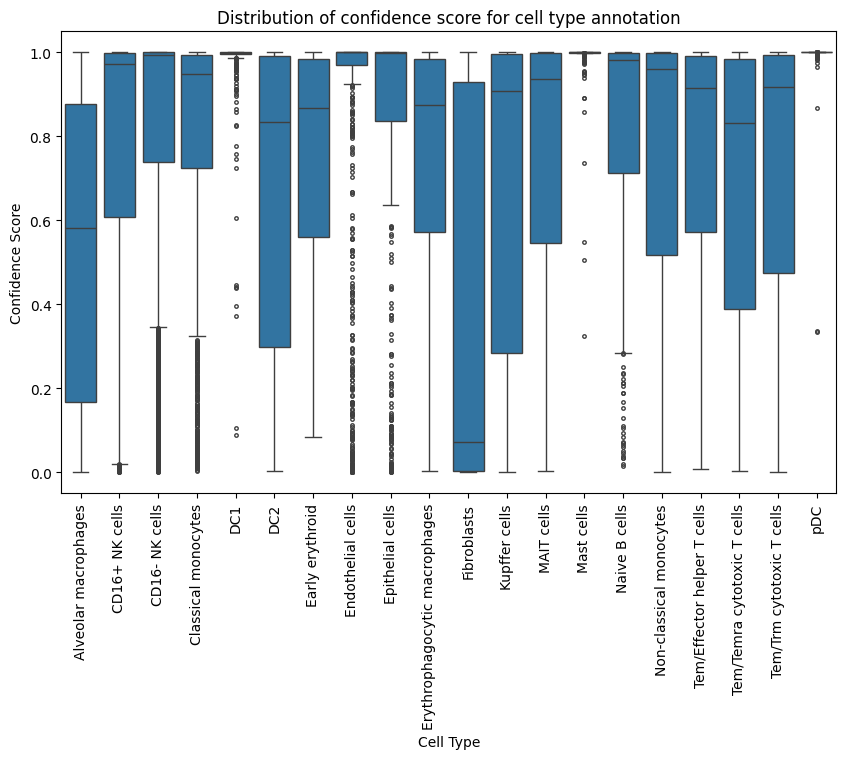

In [111]:
#boxplot of the celltypist conf scores
confscore=adata.obs['celltypist_conf_score_fine']
celltypes=adata.obs['celltypist_cell_label_fine']
boxplotdf = pd.DataFrame(confscore, columns=['Confidence Score'])
boxplotdf['Confidence Score']=confscore
boxplotdf['Cell Type']=celltypes
# Create a box plot
plt.figure(figsize=(10, 6))
sns.boxplot(x='Cell Type',
            y='Confidence Score', 
            data=boxplotdf,
           flierprops={'marker': '.', 'markersize': 5})

# Add labels and title
plt.xlabel('Cell Type')
plt.ylabel('Confidence Score')
plt.title('Distribution of confidence score for cell type annotation')

# Rotate x-axis labels for better readability
plt.xticks(rotation=90)

# Show the plot
plt.show()

In [112]:
#########################################################################################################################################
#########################################################################################################################################
#########################################################################################################################################

In [ ]:
# 2.0 Preprocessing of AIRR data

In [ ]:
#########################################################################################################################################
#########################################################################################################################################
#########################################################################################################################################

In [122]:
mdata = mu.MuData({"gex": adata, "airr": adataM_tcr})

In [ ]:
# Creating chain indices

... storing 'airr:receptor_type' as categorical
... storing 'airr:receptor_subtype' as categorical
... storing 'airr:chain_pairing' as categorical
... storing 'receptor_type' as categorical
... storing 'receptor_subtype' as categorical
... storing 'chain_pairing' as categorical


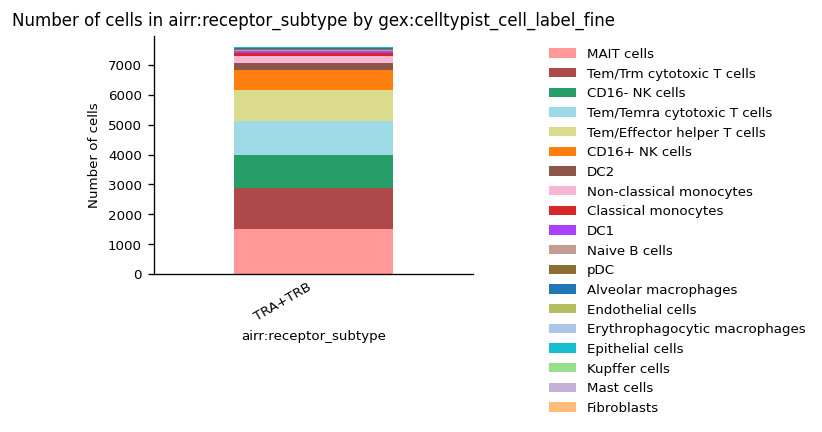

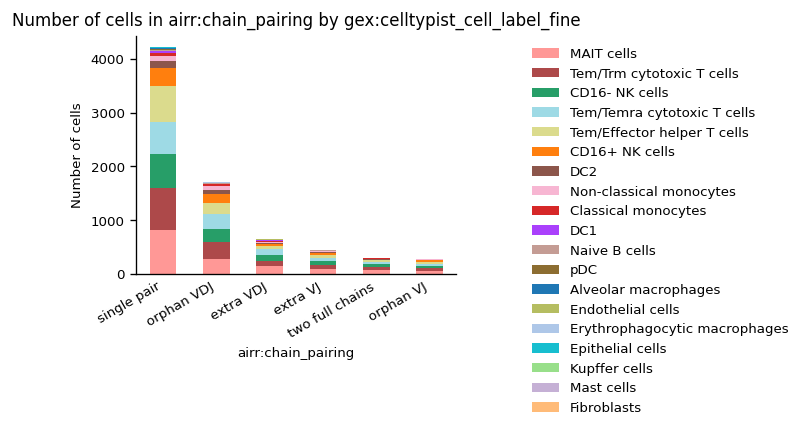

In [130]:
ir.pp.index_chains(mdata)
ir.tl.chain_qc(mdata)
_ = ir.pl.group_abundance(mdata, groupby="airr:receptor_subtype", target_col="gex:celltypist_cell_label_fine")
_ = ir.pl.group_abundance(mdata, groupby="airr:chain_pairing", target_col="gex:celltypist_cell_label_fine")

In [131]:
print(
    "Fraction of cells with more than one pair of TCRs: {:.2f}".format(
        np.sum(mdata.obs["airr:chain_pairing"].isin(["extra VJ", "extra VDJ", "two full chains", "multichain"]))
        / mdata["airr"].n_obs
    )
)

Fraction of cells with more than one pair of TCRs: 0.16


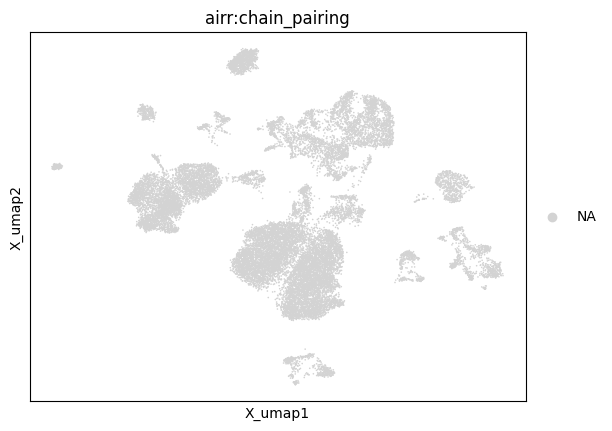

In [132]:
mu.pl.embedding(mdata, basis="gex:umap", color="airr:chain_pairing", groups="multichain")

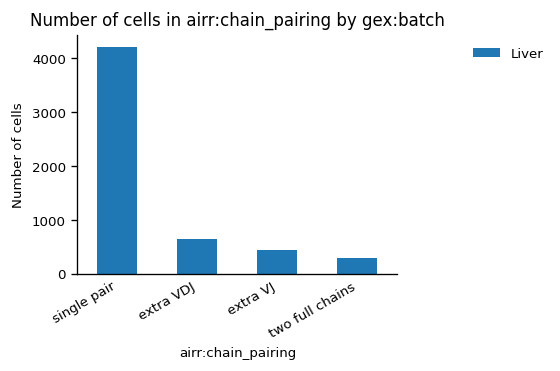

In [134]:
mu.pp.filter_obs(mdata, "airr:chain_pairing", lambda x: x != "multichain")
#Similarly, we can use the chain_pairing information to exclude all cells that don’t have at least one full pair of receptor sequences:
mu.pp.filter_obs(mdata, "airr:chain_pairing", lambda x: ~np.isin(x, ["orphan VDJ", "orphan VJ"]))
ax = ir.pl.group_abundance(mdata, groupby="airr:chain_pairing", target_col="gex:batch")

In [135]:
mdata

MuData object with n_obs × n_vars = 21699 × 25691
  obs:	'sample', 'group', 'batch'
  2 modalities
    gex:	20554 x 25691
      obs:	'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'mt_outlier', 'sample', 'group', 'batch', 'liver', 'n_genes', 'doublet_score', 'predicted_doublet', 'leiden', 'leiden_res0_25', 'leiden_res0_5', 'leiden_res1', 'celltypist_cell_label_fine', 'celltypist_conf_score_fine'
      var:	'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
      uns:	'scrublet', 'log1p', 'hvg', 'pca', 'sample_colors', 'neighbors', 'umap', 'predicted_doublet_colors', 'group_colors', 'batch_colors', 'leiden', 'leiden_res0_25', 'leiden_res0_5', 'leiden_res1', 'leiden_res0_25_colors', 'leiden_res0_5_colors', 'leiden_res1_colors', 'leiden_colors', 'celltypist_cell_label_fine_colors', 'dendrogram_celltypist_cell_label_fine', 'airr:chain_pairing_colors'
      obsm:	'X_pca', 'X_umap'
      varm:	'PCs'
      layers:	'counts'
      obsp:	'distances', 'connectivities'
    airr:	6745 x 0
      obs:	'receptor_type', 'receptor_subtype', 'chain_pairing'
      uns:	'chain_indices'
      obsm:	'airr', 'chain_indices'

In [138]:
mdata.write('msc_mdata.h5mu')